# TL;DR

We compare accuracy and performance of our custom made implementations of the [gamma function](http://mathworld.wolfram.com/GammaFunction.html), [beta](http://mathworld.wolfram.com/BetaDistribution.html) and [student-t](http://mathworld.wolfram.com/Studentst-Distribution.html) distributions to that of scipy's. The gamma function is included as it is a coefficient for these two distributions and can be numerically unstable.

Our implementation has negligible errors (usually <0.00005% relative error) and PDF point evaluations run ~4-7X faster than scipy.

This notebook contains a lot of duplicated code (sorry), but the graphs speak for themselves.

The main additions to fastats would be the `gamma`, `beta_pdf` and `t_pdf` functions.

In [1]:
import numpy as np
from numpy import log, log1p, exp, pi, power, sqrt
from numba import njit
import scipy
import matplotlib.pyplot as plt
import time

import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
# define constants used in Gamma approximations
EULER_MAS = 0.5772156649015328606065120900824024310421 # euler mascheroni constant

SMALL_GAMMA_COEFS = np.array([
    1., 0.5772156649015329, -0.6558780715202538, -0.0420026350340952, 0.1665386113822915, -0.0421977345555443,
    -0.0096219715278770, 0.0072189432466630, -0.0011651675918591, -0.0002152416741149, 0.0001280502823882,
    -0.0000201348547807, -0.0000012504934821, 0.0000011330272320, -0.0000002056338417, 0.0000000061160950,
    0.0000000050020075, -0.0000000011812746, 0.0000000001043427, 0.0000000000077823, -0.0000000000036968,
    0.0000000000005100, -0.0000000000000206, -0.0000000000000054, 0.0000000000000014, 0.0000000000000001
])

In [3]:
def rel_err(x_true, x_est):
    """
    Relative error between estimated and true value in percentage. 
    """
    dx = np.abs(x_true - x_est)
    out = dx / x_true
    return 100 * out # multiply by 100 to get percentage

There are many series expansions of the gamma and log gamma functions.

Here, we compute the relative errors against scipy for 4 different gamma approximations. This will serve as an indicator of the accuracy of our functions. We then create a function `gamma` which is a combination of the two most accurate approximations for different ranges of of the input.

In [4]:
@njit(fastmath=True)
def _gammaln_stirling(z, n=500):
    """
    Log Gamma function.
    
    Uses a variation of the Stirling series https://arxiv.org/pdf/1408.3902.pdf
    
    >>> _gammaln(10)
    12.7025861800223
    >>> _gammaln(4.782)
    2.832293314959918
    >>> _gammaln(81.009237)
    267.4853139114188
    """
    assert z > 0.
    
    out = -EULER_MAS * z - log(z)
    for k in range(1, n + 1, 4):
        # loop unrolling for speed-up
        u1 = z / k
        u2 = z / (k + 1)
        u3 = z / (k + 2)
        u4 = z / (k + 3)
        
        v1 = log1p(u1)
        v2 = log1p(u2)
        v3 = log1p(u3)
        v4 = log1p(u4)
        
        out += u1 + u2 + u3 + u4 - (v1 + v2 + v3 + v4)

    return out

@njit
def _gamma_stirling(z):
    """
    Gamma function using the Stirling approximation.
    
    Uses Abramowitz expansion 6.1.37 (Tenth printing)
    
    >>> _stirling(5)
    23.99999414518977
    >>> _stirling(9.7234)
    195449.09941496156
    >>> _stirling(3.141)
    2.2867077378658713
    """
    assert z > 0.
    
    u = exp(-z) * power(z, z - 0.5) * power(2 * pi, 0.5)
    v = 1 + 1 / (12 * z) + 1 / (288 * power(z, 2)) - 139 / (51840 * power(z, 3)) - 571 / (2488320 * power(z, 4))
    out = u * v
    return out

@njit
def _gammaln_weier(z):
    """
    Log Gamma function.
    
    Uses the Weierstrass series. Specifically given in Abramowitz 6.1.41
    
    >>> _gammaln_weier(10)
    12.801827480080647
    >>> _gammaln_weier(4.71)
    2.7507912240245926
    >>> _gammaln_weier(55.001)
    164.324110487098
    """
    assert z > 0.
    
    u = (z - 0.5) * log(z) - z + 0.5 * log(2 * pi)
    v = 1 / (12 * z) - 1 / (360 * power(z, 3)) + 1 / (1260 * power(z, 5)) - 1 / (1680 * power(z, 7))
    out = u + v
    return out

@njit(fastmath=True)
def _reciprocal_gamma(z):
    """
    Reciprocal of the Gamma function.
    
    Uses Abramowitz series expansion 6.1.34 (Tenth printing)
    
    Works very well for z < 3.
    
    >>> _reciprocal_gamma(2)
    1.0000000188842577
    >>> _reciprocal_gamma(1.414)
    1.1279166543091466
    >>> _reciprocal_gamma(1.414)
    0.09677605346350997
    """
    assert z > 0.
    
    n = SMALL_GAMMA_COEFS.shape[0]
    out = 0
    for k in range(1,n+1):
        out += SMALL_GAMMA_COEFS[k - 1] * power(z, k)
    return out

@njit
def gamma(z):
    """
    Gamma function.
    
    This function uses the two gamma functions with minimum
    error, which will be demonstrated below.
    """
    assert z > 0.
    
    threshold_ = 2.24 # this is the _reciprocal_gamma + _gammaln_weier accuracy cross-over
    if z < threshold_:
        return 1 / _reciprocal_gamma(z)
    else:
        return exp(_gammaln_weier(z))

### Calculate errors
We take the exponent where necessarry to compute the gamma function.

All errors are in gamma space (not log gamma).

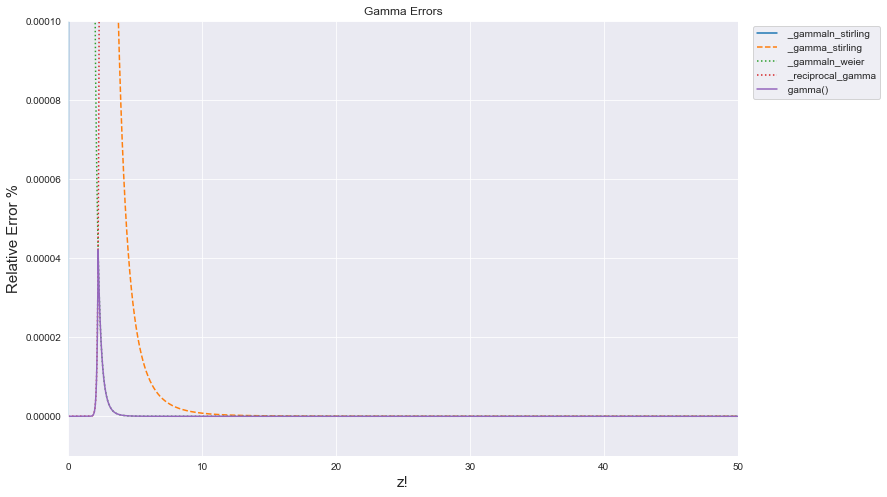

In [5]:
zs = np.linspace(0.001, 100, 10000) # domain over which we calculate gamma

errs1 = np.array([rel_err(scipy.special.gamma(z), exp(_gammaln_stirling(z))) for z in zs])
errs2 = np.array([rel_err(scipy.special.gamma(z), _gamma_stirling(z)) for z in zs])
errs3 = np.array([rel_err(scipy.special.gamma(z), exp(_gammaln_weier(z))) for z in zs])
errs4 = np.array([rel_err(scipy.special.gamma(z), 1 / _reciprocal_gamma(z)) for z in zs])
errs5 = np.array([rel_err(scipy.special.gamma(z), gamma(z)) for z in zs])

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(zs, errs1, label=" _gammaln_stirling", linestyle='-');
ax.plot(zs, errs2, label=" _gamma_stirling", linestyle='--');
ax.plot(zs, errs3, label=" _gammaln_weier", linestyle=':');
ax.plot(zs, errs4, label=" _reciprocal_gamma", linestyle=':');
ax.plot(zs, errs5, label=" gamma()", linestyle='-');

ax.legend();
ax.set_title("Gamma Errors")
ax.set_xlabel("z!", fontsize=15);
ax.set_ylabel("Relative Error %", fontsize=15);
ax.legend(bbox_to_anchor=(1.22, 1.));

# change the limits below to see how small the errors are
ax.set_ylim(-0.00001, 0.0001);
ax.set_xlim(0,50);

The relative errors for `gamma` are small (<0.00001%) for both small and large values of z!

We see that combining `_reciprocal_gamma` for small values and `_gammaln_weier` for larger values yields optimal results.

Since we've proven `gamma` has the smallest relative error for values of $0<z<100$, we will use it in our beta and student-t distributions from here on in.


# Statistical Distance

It would be naive to use the relative error metric to evaluate our PDF implementation against that of scipy's. This is because the relative error is a point metric. Instead, we use the [Hellinger Distance](https://en.wikipedia.org/wiki/Hellinger_distance) which is a measure of similarity between two probability distributions. One can think of it as the amount of overlap between two distributions PDF's. For two distributions $P$ and $Q$, it is given by

$$H(P,Q) = \frac{1}{\sqrt{2}} \sqrt{\sum_{i=1}^k (\sqrt{p_i} - \sqrt{q_i})^2}$$

The closer $H$ is to zero, the more similar two distributions are. We wan't our hellinger distance to be zero as this indicates our implementation is as close to scipy's as possible.

There are many metrics that can be used to measure statisicatl distance (KL-divergence, Bhattacharyya, Jensen-Shannon). I'm just using Hellinger because its easy and fast to implement.

## Beta distribution PDF accuracy

In [6]:
@njit
def beta_pdf(x, a, b):
    u = gamma(a + b) * power(1 - x, b - 1) * power(x, a - 1)
    v = gamma(a) * gamma(b)
    out = u / v
    return out

In [7]:
@njit(fastmath=True)
def hellinger(p,q):
    """Hellinger distance between two probability distributions p and q"""
    out = 0
    n = p.shape[0]
    for i in range(n):
        u = sqrt(p[i]) - sqrt(q[i])
        u = power(u, 2)
        out += u
    out = sqrt(0.5 * out)
    return out

We'll evaluate the beta pdf over a range of x points and for random values of parameters alpha and beta values.

For each value of alpha and beta, we get a unique PDF. We will compute the hellinger distance for each unique PDF and plot the result

In [8]:
n_points = 1000
n_params = 1000
xs = np.linspace(0.001, 0.999, n_points) # evaluate pdf in this range
alphas = np.random.uniform(0.1, 10, n_params)
betas = np.random.uniform(0.1, 10, n_params)

def get_errs():
    errs = np.zeros(n_params)
    for i in range(n_params):
        bpdf = beta_pdf(xs, alphas[i], betas[i])
        spdf = scipy.stats.beta(alphas[i], betas[i]).pdf(xs)
        errs[i] = hellinger(bpdf, spdf)
    return errs

errs = get_errs()

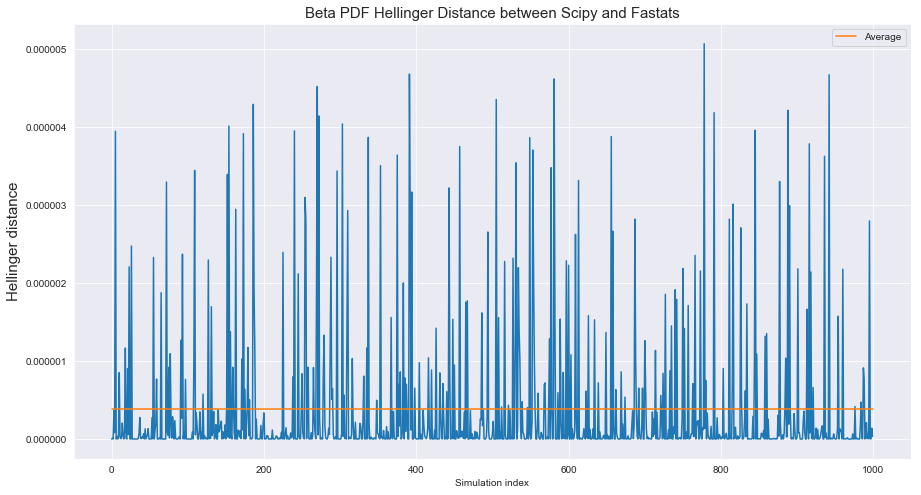

In [9]:
fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(x=np.arange(len(errs)),y=errs, ax=ax);
sns.lineplot(x=np.arange(len(errs)),y=errs.mean(), ax=ax, label="Average");
ax.set_xlabel("Simulation index");
ax.set_ylabel("Hellinger distance", fontsize=15);
ax.set_title("Beta PDF Hellinger Distance between Scipy and Fastats", fontsize=15);

Most values for the hellinger distance are very small (<0.000006). This indicates that are beta pdf implementation is working well.

# Student-t distribution PDF accuracy

We'll carry out the same accuracy analysis with a range of x-values and random $\nu$ values for the t distribution.

In [10]:
@njit
def t_pdf(x, nu):
    u = gamma(0.5 * (nu + 1))
    v1 = sqrt(nu * pi) * gamma(0.5 * nu)
    v2 = power(1 + power(x, 2) / nu, 0.5 * (nu + 1))
    out = u / (v1 * v2)
    return out# Beta distribution PDF evaluation accuracy

In [11]:
n_points = 1000
n_params = 1000
xs = np.linspace(-20, 20, n_points) # evaluate pdf in this range
nus = np.random.uniform(1,30,n_params)

def get_errs():
    errs = np.zeros(n_params)
    for i in range(n_params):
        bpdf = t_pdf(xs, nus[i])
        spdf = scipy.stats.t(nus[i]).pdf(xs)
        errs[i] = hellinger(bpdf, spdf)
    return errs

errs = get_errs()

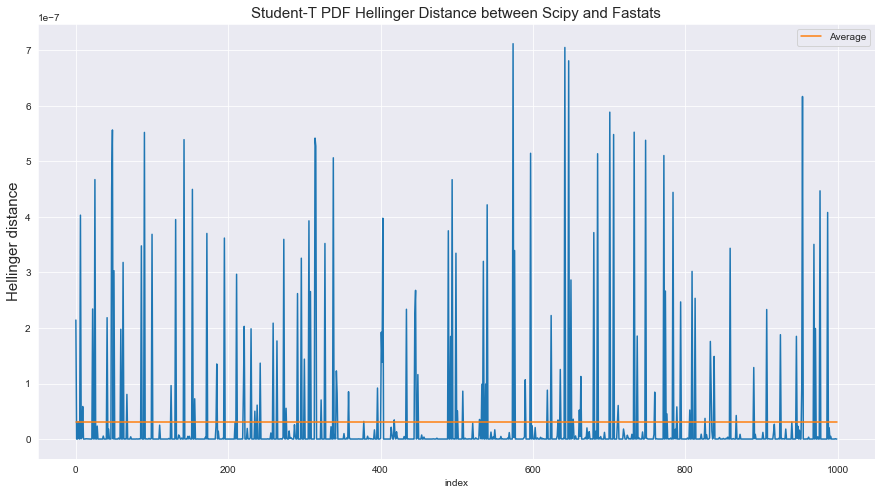

In [12]:
fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(x=np.arange(len(errs)),y=errs, ax=ax);
sns.lineplot(x=np.arange(len(errs)),y=errs.mean(), ax=ax, label="Average");
ax.set_xlabel("index");
ax.set_ylabel("Hellinger distance", fontsize=15);
ax.set_title("Student-T PDF Hellinger Distance between Scipy and Fastats", fontsize=15);

Again, the Hellinger distance for the t distribution is extremely small (most are < $7\times 10^{-7}$).

### Just for good measure, we'll overlay some fastats and scipy PDFs to visualise how close they are.

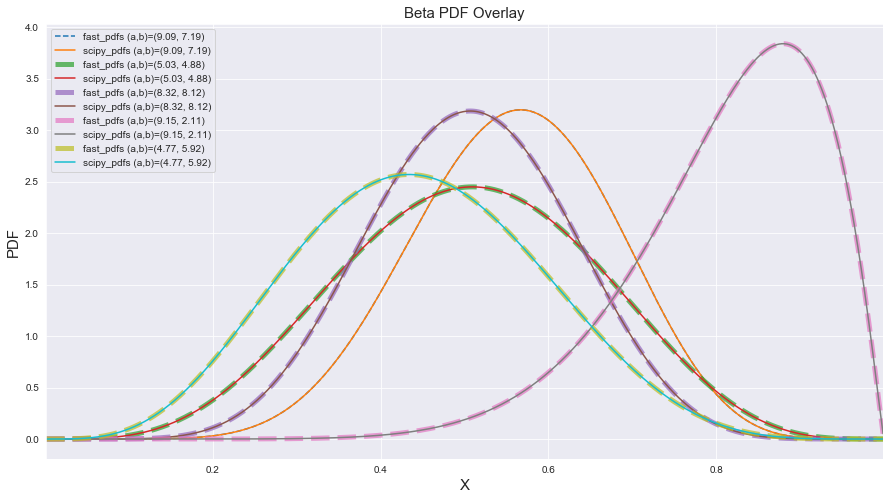

In [13]:
import re # regex

n = 5
alphas = np.random.uniform(1,10,n)
betas = np.random.uniform(1,10,n)
xs = np.linspace(0.001, 0.999, 1000)

df = pd.DataFrame({'X':xs})

for a,b in zip(alphas,betas):
    df['fast_pdfs (a,b)={}'.format((round(a, 2),round(b, 2)))] = beta_pdf(xs, a, b)
    df['scipy_pdfs (a,b)={}'.format((round(a, 2),round(b, 2)))] = scipy.stats.beta(a, b).pdf(xs)
    
# this part is a bit clunky :(
# plot fastats as thicker dashed lines --
# plot scipy as a solid line
for i in range(1,len(df.columns)):
    if i == 1:
        ax = df.plot(x='X', y=df.columns[i], linestyle='--', figsize=(15,8))
    else:
        if re.search(r"fast", df.columns[i]):
            df.plot(x='X', y=df.columns[i], ax=ax, linestyle='--', lw=5, alpha=0.7)
        else:
            df.plot(x='X', y=df.columns[i], ax=ax)

ax.set_xlabel("X", fontsize=15);
ax.set_ylabel("PDF", fontsize=15);
ax.set_title("Beta PDF Overlay", fontsize=15);

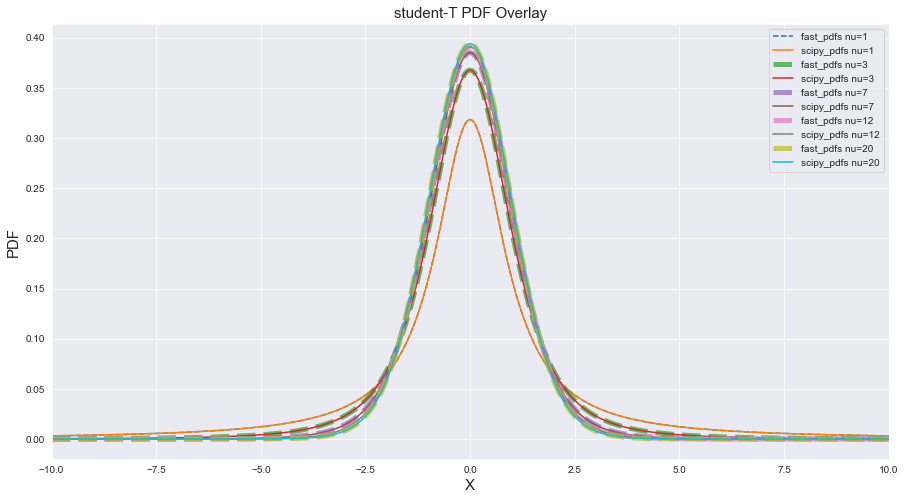

In [14]:
import re # regex

n = 5
nus = [1,3,7,12,20]
xs = np.linspace(-10, 10, 1000)

df = pd.DataFrame({'X':xs})

for nu in nus:
    df['fast_pdfs nu={}'.format(round(nu,2))] = t_pdf(xs, nu)
    df['scipy_pdfs nu={}'.format(round(nu,2))] = scipy.stats.t(nu).pdf(xs)
    
# this part is a bit clunky :(
# plot fastats as thicker dashed lines --
# plot scipy as a solid line
for i in range(1,len(df.columns)):
    if i == 1:
        ax = df.plot(x='X', y=df.columns[i], linestyle='--', figsize=(15,8))
    else:
        if re.search(r"fast", df.columns[i]):
            df.plot(x='X', y=df.columns[i], ax=ax, linestyle='--', lw=5, alpha=0.7)
        else:
            df.plot(x='X', y=df.columns[i], ax=ax)

ax.set_xlabel("X", fontsize=15);
ax.set_ylabel("PDF", fontsize=15);
ax.set_title("student-T PDF Overlay", fontsize=15);

The difference between our implementation and scipy's is visually indistinguishable.

But how fast is our implementation? We'll check that next.


# PDF performance

We'll now evaluate the PDF of both the beta and student-t distributions for 10,000 points in a range. This is performed 10,000 times for different random values of input parameters $\alpha$, $\beta$ and $\nu$. For each vector of points $x$ and corresponding parameters $(\alpha, \beta)$, $(\nu)$, we time our PDF implementation and benchmark it against that of scipy's.

In [15]:
n_points = 10000 # number of points on x domain
n_sim = 10000 # number of simulations

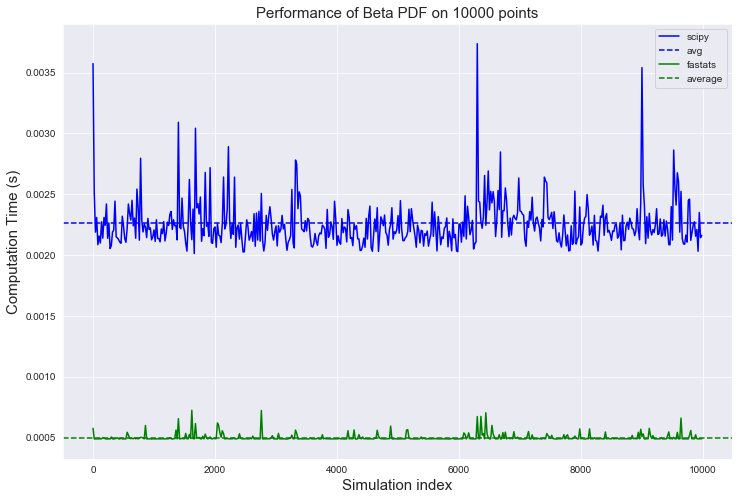

In [16]:
xs = np.linspace(0.001, 0.999, n_points) # get pdf for points in this range
runtimes_scipy = np.zeros(n_sim)
runtimes_fastats = np.zeros(n_sim)

for i in range(n_sim):
    # choose alpha and beta randomly for each simulation
    a = np.random.uniform(1,10)
    b = np.random.uniform(1,10)
    
    # scipy
    start = time.time()
    scipy.stats.beta(a,b).pdf(xs)
    end = time.time()
    runtimes_scipy[i] = end - start

    # fastats
    # we run the lines below twice
    # first time to compile with jit
    # second time to get accurate timing
    start = time.time()
    beta_pdf(xs, a, b)
    end = time.time()
    ###################
    start = time.time()
    beta_pdf(xs, a, b)
    end = time.time()
    runtimes_fastats[i] = end - start

fig, ax = plt.subplots(figsize=(12,8))
# there's a lot of points, so we skip every 20 steps
step = 20
ax.plot(np.arange(n_sim)[::step], runtimes_scipy[::step], label="scipy", color='b');
ax.axhline(y=runtimes_scipy.mean(), label="avg", linestyle="--", color='b')

ax.plot(np.arange(n_sim)[::step], runtimes_fastats[::step], label="fastats", color='g');
ax.axhline(y=runtimes_fastats.mean(), label="average", linestyle="--", color='g')
ax.set_title("Performance of Beta PDF on {} points".format(n_points), fontsize=15)
ax.set_xlabel("Simulation index", fontsize=15)
ax.set_ylabel("Computation Time (s)", fontsize=15)
ax.legend();

In [17]:
# this is how many times faster our implementation is than scipy on average
runtimes_scipy.mean()/runtimes_fastats.mean()

4.524591696172508

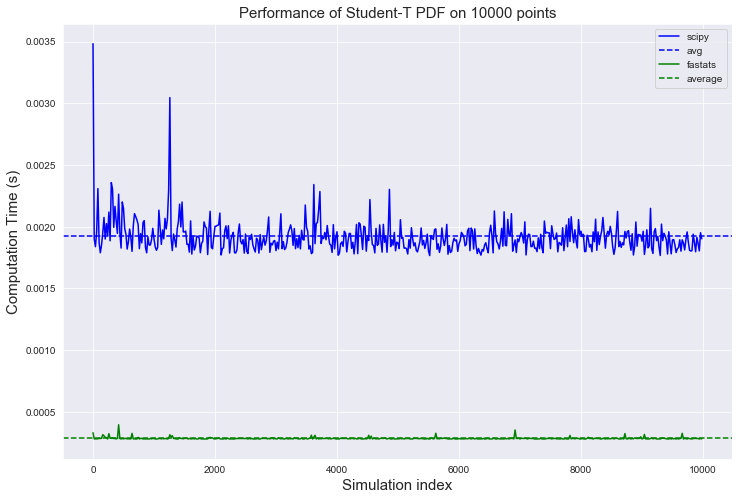

In [18]:
xs = np.linspace(-20, 20, n_points) # get pdf for points in this range
n_sim = 10000
runtimes_scipy = np.zeros(n_sim)
runtimes_fastats = np.zeros(n_sim)

for i in range(n_sim):
    nu = np.random.uniform(1,30) # choose nu randomly for each simulation
    
    # scipy
    start = time.time()
    scipy.stats.t(nu).pdf(xs)
    end = time.time()
    runtimes_scipy[i] = end - start

    # fastats
    # we run the lines below twice
    # first time to compile with jit
    # second time to get accurate timing
    start = time.time()
    t_pdf(xs, nu)
    end = time.time()
    ######################
    start = time.time()
    t_pdf(xs, nu)
    end = time.time()
    runtimes_fastats[i] = end - start

fig, ax = plt.subplots(figsize=(12,8))
# there's a lot of points, so we skip every 20 steps
step = 20
ax.plot(np.arange(n_sim)[::step], runtimes_scipy[::step], label="scipy", color='b');
ax.axhline(y=runtimes_scipy.mean(), label="avg", linestyle="--", color='b')

ax.plot(np.arange(n_sim)[::step], runtimes_fastats[::step], label="fastats", color='g');
ax.axhline(y=runtimes_fastats.mean(), label="average", linestyle="--", color='g')
ax.set_title("Performance of Student-T PDF on {} points".format(n_points), fontsize=15)
ax.set_xlabel("Simulation index", fontsize=15)
ax.set_ylabel("Computation Time (s)", fontsize=15)
ax.legend();

In [19]:
# this is how many times faster our implementation is than scipy on average
runtimes_scipy.mean()/runtimes_fastats.mean()

6.771786975246739

# Conclusions

* Our `gamma` function seems to be almost as accurate as the scipy implementation; at worst there is a relative error of 0.00005% for any given value of $0<z<100$

* Our `beta_pdf` and `t_pdf` have very small Hellinger distances ($<10^{-6}$) for a range of input parameters.

* The PDF point evaluation for both the beta and student-t distributions outperform scipy in computation time, as well as having a smaller variances in computation time, as can be seen in the last two graphs above.